In [1]:
from model import *
from preprocess import *
from train import *
from utils import *
from decode import *

In [2]:
raw_text = read_data_nmt('fra.txt') # len: 11489286

In [3]:
text = preprocess_nmt(raw_text) # len: same as raw_text
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [4]:
source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

In [8]:
source_len = [len(s) for s in source]
target_len = [len(t) for t in target]
src_avg = sum(source_len)/len(source_len)
tgt_avg = sum(target_len)/len(target_len)


In [9]:
src_avg, tgt_avg

(7.217704780709627, 7.584544964997307)

TypeError: text() missing 2 required positional arguments: 'y' and 's'

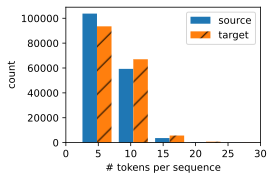

In [6]:
show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target)

In [ ]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

In [ ]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()

batch_size, num_steps =4, 7
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
output, state = encoder(X)

In [ ]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)

In [ ]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long),torch.tensor([4, 2, 0]))

In [ ]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
# train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)


In [ ]:
net

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

In [ ]:
from preprocess import *
from utils import *
import torch
import matplotlib.pyplot as plt
import numpy as np
from d2l import torch as d2l

In [ ]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False, debug = True):
    """Predict for sequence to sequence."""
    # Set `net` to eval mode for inference
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    if debug == True:
        print(f'src_tokens: {src_tokens}')
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # Add the batch axis
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # Add the batch axis
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    if debug:
        print(f'src_sentence: {src_sentence}')
        print(f'enc_valid_len: { enc_valid_len}')
        print(f'src_tokens_truncate: {src_tokens}')
        print(f'enc_X: {enc_X}')
        print(f'enc_outputs: {enc_outputs}')
        print(f'dec_state: {dec_state}')
        print(f'dec_X: {dec_X}')
        # print(f': {}')
        # print(f': {}')
        # print(f': {}')
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # We use the token with the highest prediction likelihood as the input
        # of the decoder at the next time step
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # Once the end-of-sequence token is predicted, the generation of the
        # output sequence is complete
        if debug:
            print(f'Y: {Y} Y shape: {Y.shape}')
            print(f'dec_X: {dec_X}')
            print(f'pred: {pred}')
            print(f'Y around: {Y[:,:,pred-5:pred+5]}')
            
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq


In [ ]:
en = read_data_nmt('val.lc.norm.tok.en')
engs = en.split('\n')
fr = read_data_nmt('val.lc.norm.tok.fr')
fras = fr.split('\n')

net = torch.load('Seq2Seq.pt')
net.eval()
device = d2l.try_gpu()
num_steps = 14
src_vocab = torch.load('src_vocab.pth')
tgt_vocab = torch.load('tgt_vocab.pth')
bleu_dist = []
for eng, fra in zip(engs[:1], fras[:1]):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=1):.3f}')
    bleu_dist.append(bleu(translation, fra, k=1))
# plt.hist(bleu_dist, bins=100)
# plt.gca().set(title='BLEU Score Frequency Histogram: Greedy Decode', ylabel='Frequency',xlabel='BLEU Score')
# plt.savefig('evaluate.png')
# print(f'Average {round(sum(bleu_dist)/len(bleu_dist),3)}, variance {np.var(bleu_dist)}')

In [25]:
def rdn_roll(p_dist):
    tl = sum(p_dist)
    n_dist = [p/tl for p in p_dist]
    print(n_dist)
    acml = [sum(n_dist[:i]) for i in range(len(n_dist))] 
    acml.extend([1])
    return acml
import random

In [35]:
p_dist = [0.9919733777744411, 0.40705440888732897, 0.4050494469545701, 0.34769653211122753, 0.33410693764577826]
tl = sum(p_dist)
n_dist = [p/tl for p in p_dist]
a = [1,2,3,4,5]
random.choices(a, weights = n_dist, k = 10)

[3, 1, 2, 2, 2, 1, 1, 1, 4, 5]